In [2]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 100

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import requests

from os import listdir
import unicodedata

from paths import *
from scripts.manipulation import remove_acentos
from scripts.manipulation import normalize_cols
from scripts import scrap_data
from scripts import manipulation
from scripts import manipulation_sp

from scripts import io
from scripts import vis_graphs

from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')

import yaml


Boletim SP

https://www.seade.gov.br/coronavirus/?utm_source=portal&utm_medium=banner&utm_campaign=boletim-completo

## Casos

In [3]:
casos_full = pd.read_csv('https://raw.githubusercontent.com/seade-R/dados-covid-sp/master/data/dados_covid_sp.csv', sep=';')
casos, sp_casos = manipulation_sp.padronize_casos(casos_full)

## Internacoes

In [4]:
internacoes_full = pd.read_csv('https://github.com/seade-R/dados-covid-sp/raw/master/data/plano_sp_leitos_internacoes.csv', sep=';')
internacoes, sp_internacoes = manipulation_sp.padronize_internacoes(internacoes_full)

## Ocupacao UTI

In [5]:
uti = pd.read_csv('../data/sp_gov/uti_ocupacao.csv', sep=';')

uti_final = uti.copy()


# mask =  uti_final['datahora'] == max(uti_final['datahora'])

# uti_final = uti_final[mask]

# uti_final['datahora'] = max(df_final['datahora'])

## Add Fases

In [6]:
#merge all tables
df = manipulation_sp.padronize_planosp(sp_casos,sp_internacoes, uti_final)

df = manipulation_sp.add_fases(df)

# padronize names and column names
df = manipulation_sp.padronize_planosp_names(df)

In [7]:
df.head()

,Data,DRS,Capacidade Hospitalar,Ocupação leitos UTI COVID,Leitos COVID/100 mil hab,Evolução da Pandemia,Variação de casos,Variação internações,Variação de óbitos,Classif. Final
107,2020-08-13,00 - Estado de São Paulo,4.0,57.8,21.73,2.8,1.09,0.98,1.08,2.8
105,2020-07-30,00 - Estado de São Paulo,4.0,64.0,20.85,3.0,1.55,0.99,0.97,3.0
104,2020-07-23,00 - Estado de São Paulo,4.0,67.0,20.44,3.2,0.95,0.96,0.97,3.2
103,2020-07-16,00 - Estado de São Paulo,4.0,65.0,20.48,2.2,1.1,1.07,1.09,2.2
102,2020-07-09,00 - Estado de São Paulo,4.0,65.0,20.21,2.4,0.89,1.01,1.11,2.4


## Colored Table

In [8]:
mask = df['Data']==max(df['Data'])
pd.options.display.float_format = '{:,.2f}'.format

df[mask].style.applymap(manipulation_sp.cases_color, subset=pd.IndexSlice[:, ['Capacidade Hospitalar','Evolução da Pandemia','Classif. Final']] )

,Data,DRS,Capacidade Hospitalar,Ocupação leitos UTI COVID,Leitos COVID/100 mil hab,Evolução da Pandemia,Variação de casos,Variação internações,Variação de óbitos,Classif. Final
107,2020-08-13,00 - Estado de São Paulo,4.0,57.8,21.73,2.8,1.09,0.98,1.08,2.8
53,2020-08-13,DRS 01 - Município de São Paulo,4.0,58.0,30.35,2.2,1.36,1.0,1.24,2.2
11,2020-08-13,DRS 02 - Araçatuba,4.0,50.1,17.00,2.4,1.0,1.22,0.82,2.4
5,2020-08-13,DRS 03 - Araraquara,4.0,37.4,15.27,2.0,1.1,1.18,2.64,2.0
17,2020-08-13,DRS 04 - Baixada Santista,4.0,34.4,26.68,3.4,1.08,0.79,1.21,3.4
23,2020-08-13,DRS 05 - Barretos,4.0,70.4,18.05,2.0,1.09,1.12,3.29,2.0
29,2020-08-13,DRS 06 - Bauru,4.0,65.3,12.27,3.2,0.87,0.99,0.7,3.2
35,2020-08-13,DRS 07 - Campinas,4.0,62.9,20.84,2.8,1.02,0.9,1.03,2.8
41,2020-08-13,DRS 08 - Franca,2.4,77.9,12.08,2.8,1.04,0.67,1.65,2.4
47,2020-08-13,DRS 09 - Marília,4.0,45.7,15.36,2.8,0.93,1.07,0.67,2.8


## Indicadores Comparacoes

In [28]:
from scripts import io

# get casos e internacoes
casos, sp_casos = manipulation_sp.padronize_casos(casos_full)
internacoes, sp_internacoes = manipulation_sp.padronize_internacoes(internacoes)

#get plano sp fases by region
planosp = io.read_sheets('Plano SP','df')
planosp['date'] = pd.to_datetime(planosp['date'], format="%d/%m/%Y")
colors = {"1":"red","2":"orange","3":"yellow","4":"green"}
planosp['fase'] = planosp['fase'].map(colors)
colors = {"parcial":"lightgrey","final":"black"}
planosp['att'] = planosp['att'].map(colors)


final = manipulation_sp.padronize_planosp_parameters(sp_casos,sp_internacoes)

In [29]:

cols = ['datahora','nome_drs','casos_var','internacoes_var','obitos_var','internacoes_14d_pc','obitos_14d_pc']
ev = final[cols]
dd = manipulation_sp.add_fases_only_evolution(ev).sort_values(by=['DRS','Data'])


mask = dd['Data']==max(dd['Data'])
pd.options.display.float_format = '{:,.2f}'.format

dd[mask].style.applymap(manipulation_sp.cases_color, subset=pd.IndexSlice[:, ['Evolução da Pandemia']] )

,Data,DRS,Evolução da Pandemia,Variação de casos,Variação internações,Variação de óbitos
2423,2020-08-19,00 - Estado de São Paulo,3.2,0.95,0.99,0.98
1245,2020-08-19,DRS 01 - Município de São Paulo,3.2,0.89,0.99,0.89
230,2020-08-19,DRS 02 - Araçatuba,3.6,0.77,0.79,1.3
118,2020-08-19,DRS 03 - Araraquara,3.4,0.96,0.9,0.69
361,2020-08-19,DRS 04 - Baixada Santista,3.6,0.69,0.98,1.26
472,2020-08-19,DRS 05 - Barretos,3.0,1.2,0.8,0.89
602,2020-08-19,DRS 06 - Bauru,2.8,0.93,1.05,0.85
737,2020-08-19,DRS 07 - Campinas,3.0,1.11,0.96,0.93
830,2020-08-19,DRS 08 - Franca,2.2,1.16,1.03,1.71
1096,2020-08-19,DRS 09 - Marília,2.2,1.2,1.12,1.42


In [30]:
(4 + 2*3 + 3 )/ 5

2.6

In [31]:
def get_figure(final,DRSs,var,title,planosp):
    
    data = []
    y_min, y_max = [], []
    for drs in DRSs:
        dd = final[final['nome_drs']==drs]
        
        trace = go.Scatter(
                name=f'{drs}',
                x=dd['datahora'], 
                y=dd[var],
                mode='lines+markers',
                line=dict(width=4),

            )
        
        data.append(trace)
        
        y_min.append(dd[var].min())
        y_max.append(dd[var].max())
        
    layout =  go.Layout(height=720,barmode='group')

    fig = go.Figure(data=data, layout=layout)
    
    lw=2
    
    planosp_filter = planosp[planosp['drs'].isin([drs])]
    for (date,color) in zip(planosp_filter['date'],planosp_filter['att']):
#         print(color)
        fig.add_shape(
            # Line Horizontal
                type="line",
                x0=date,
                y0=min(y_min)*0.9,
                x1=date,
                y1=max(y_max)*1.1,
                line=dict(
                    color=color,
                    width=lw,
                    dash="dashdot",
                ),
        )

    fig.update_layout(title = title, hovermode= 'x unified',legend = go.layout.Legend(orientation='h'), xaxis_title='', yaxis_title=title, font = dict(size=22))
    
    return fig

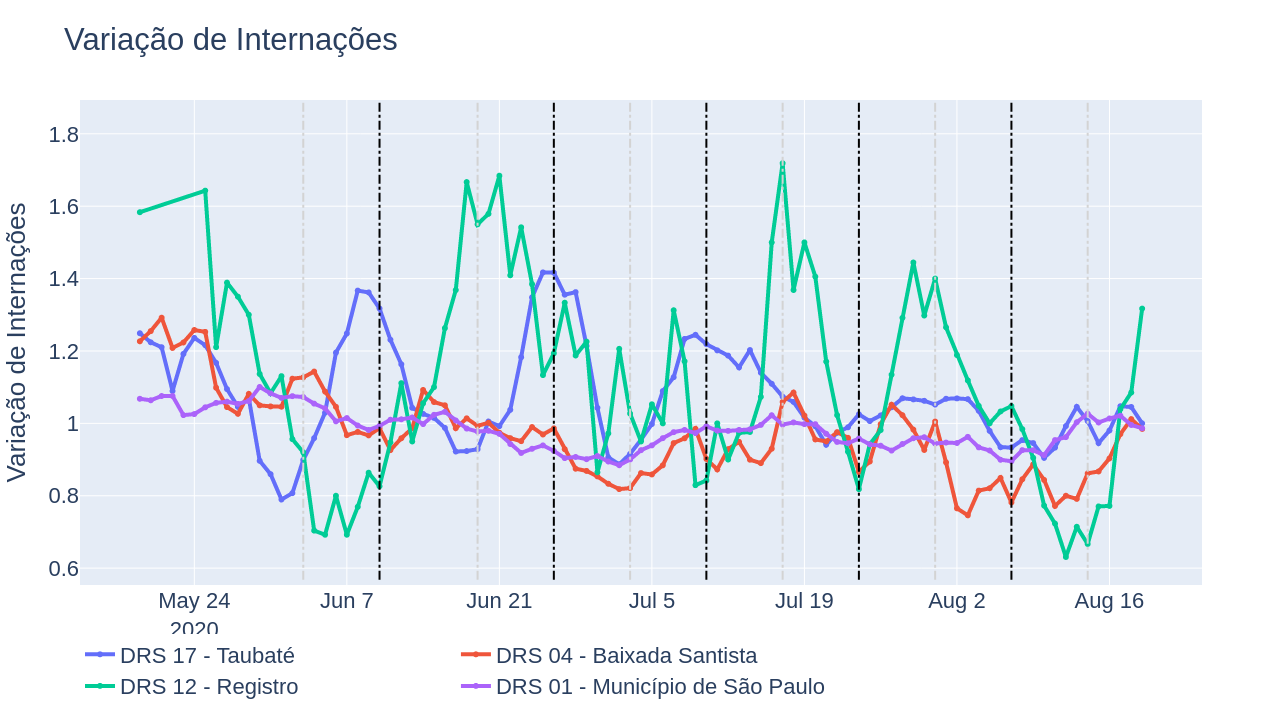

In [32]:
DRSs = ['DRS 17 - Taubaté','DRS 04 - Baixada Santista','DRS 12 - Registro','DRS 01 - Município de São Paulo']
# DRSs = final['nome_drs'].unique()

var = 'internacoes_var'
title = 'Variação de Internações'
get_figure(final,DRSs,var,title,planosp)


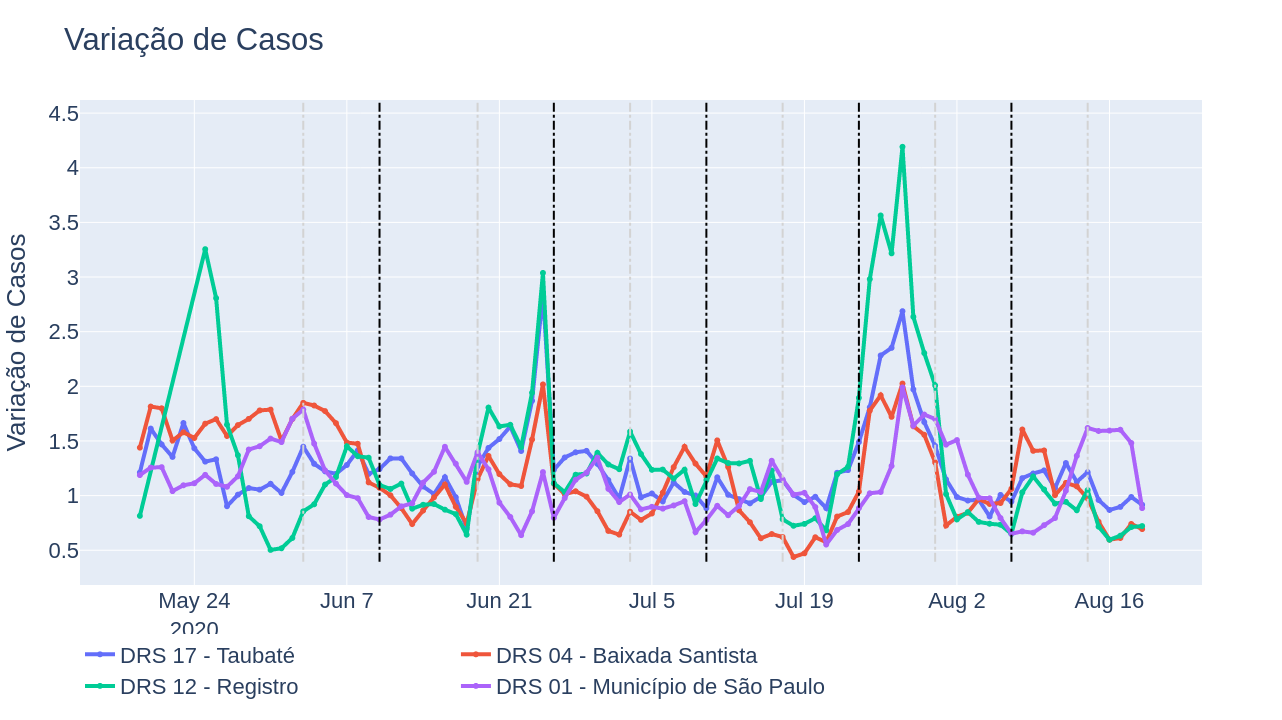

In [33]:
var = 'casos_var'
title = 'Variação de Casos'
get_figure(final,DRSs,var,title,planosp)


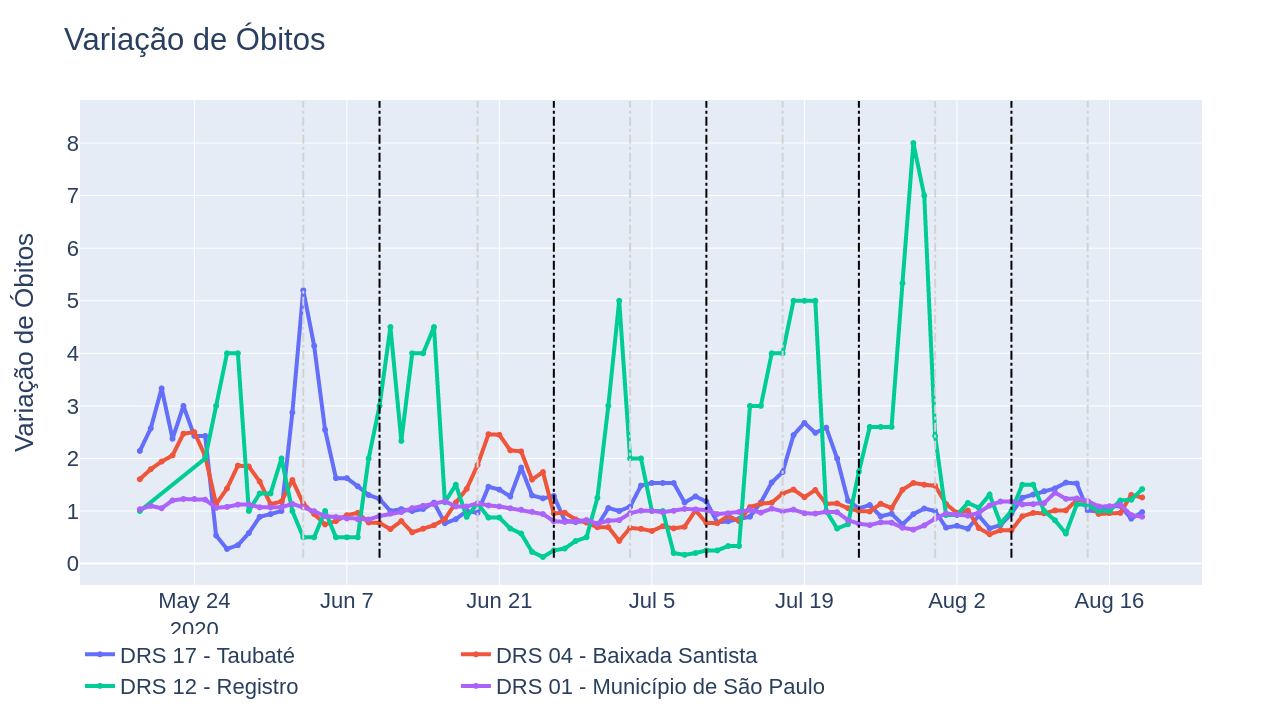

In [34]:
var = 'obitos_var'
title = 'Variação de Óbitos'
get_figure(final,DRSs,var,title,planosp)


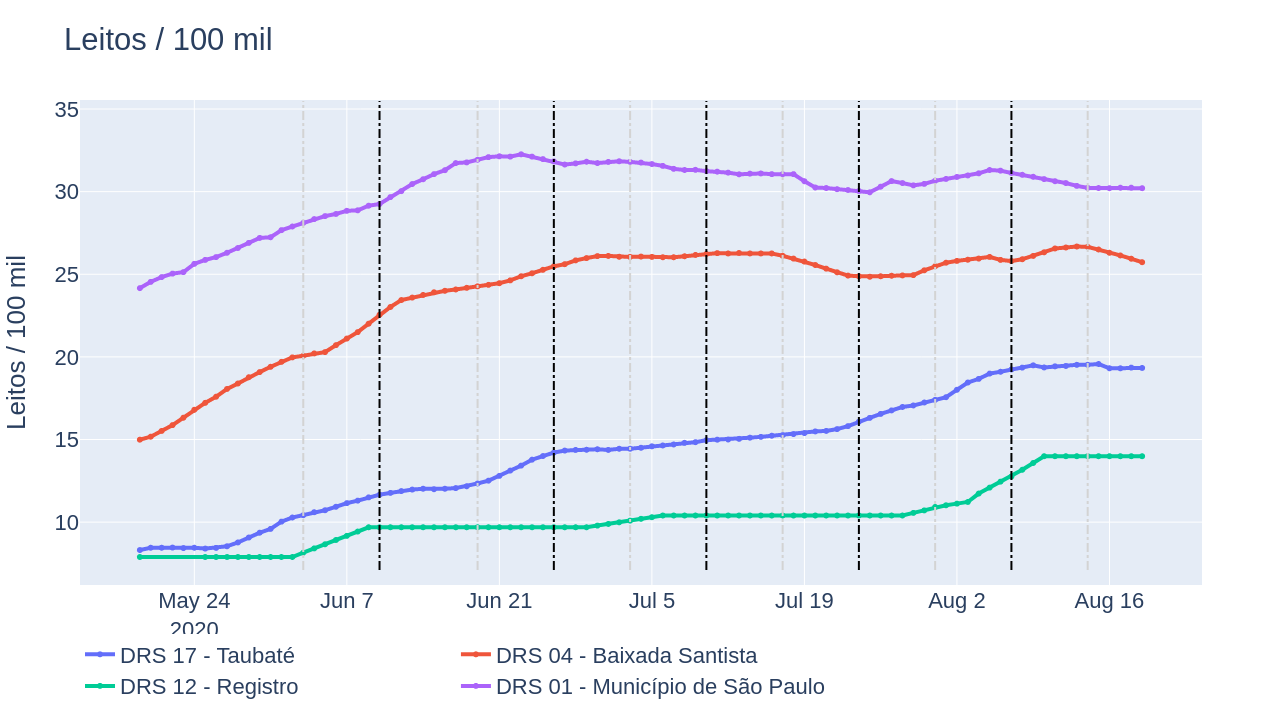

In [35]:
var = 'leitos_pc'
title = 'Leitos / 100 mil'
get_figure(final,DRSs,var,title,planosp)


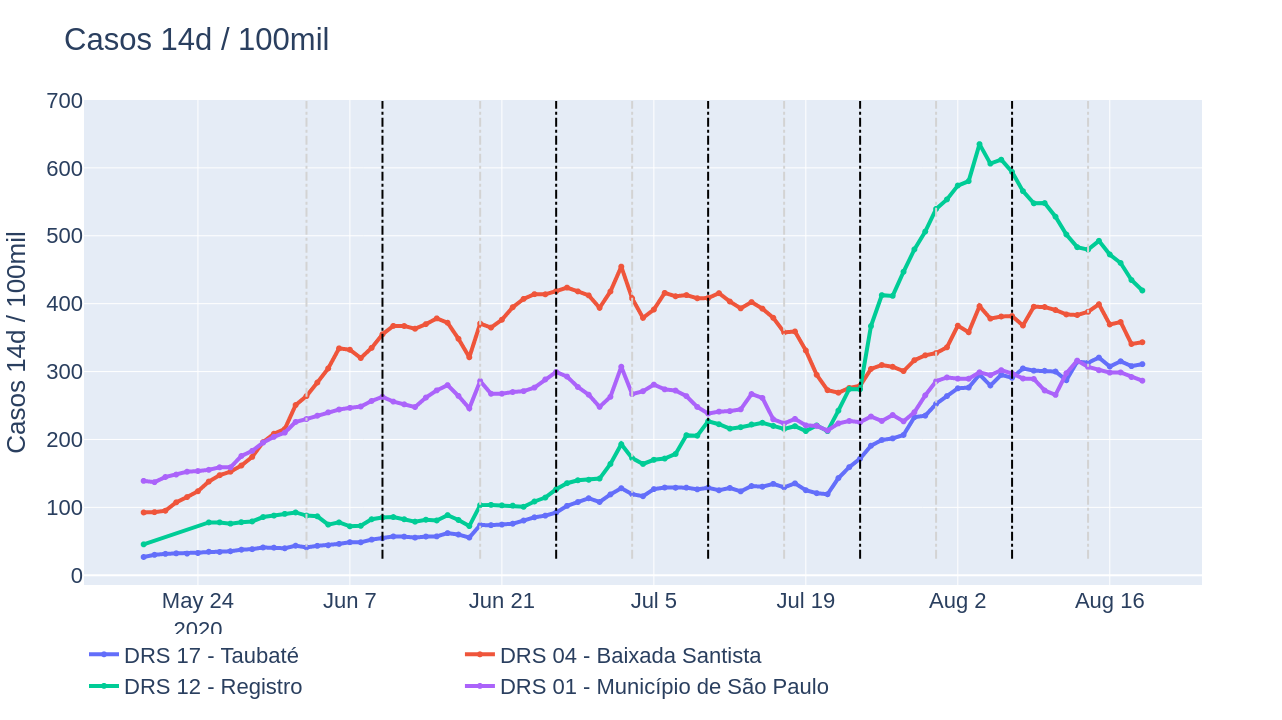

In [36]:
var = 'casos_14d_pc'
title = 'Casos 14d / 100mil'
get_figure(final,DRSs,var,title,planosp)


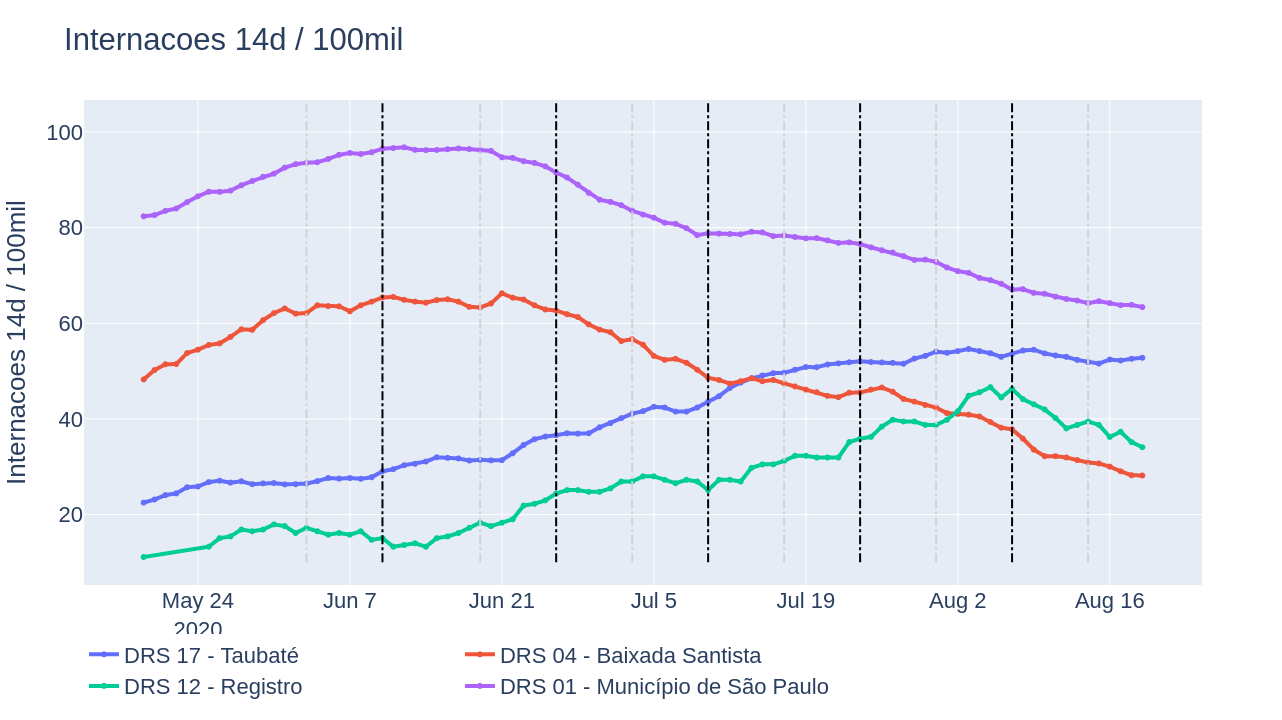

In [37]:
var = 'internacoes_14d_pc'
title = 'Internacoes 14d / 100mil'
get_figure(final,DRSs,var,title,planosp)


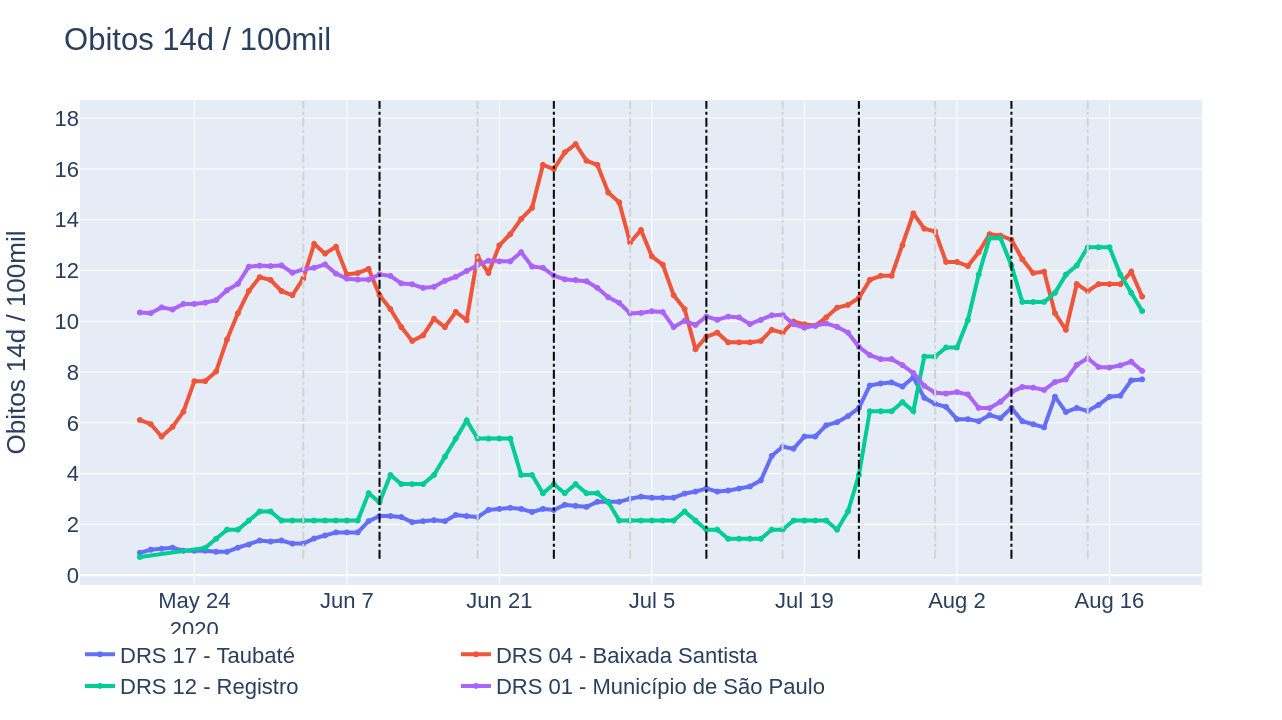

In [38]:
var = 'obitos_14d_pc'
title = 'Obitos 14d / 100mil'
get_figure(final,DRSs,var,title,planosp)


## Indicadores Unicos

In [39]:
def get_figure_bar(final,drs,var,var_mm,title,planosp):
    mask  = final['nome_drs'].isin([drs])
    final = final[mask]
    
    
    trace1 = go.Bar(
            name=f'{drs} - {title}',
            x=final['datahora'], 
            y=final[var],
        )
    if var_mm != '':
        trace2 = go.Scatter(
                name=f'{drs} - Média móvel 7 dias',
                x=final['datahora'], 
                y=final[var_mm],
                mode='lines+markers',
                line=dict(width=4, color='blue'),
            )

        data = [trace1,trace2]
    else:
        data = [trace1]

    
    layout =  go.Layout(height=720,barmode='group')
    
    fig = go.Figure(data=data, layout=layout)
    
    lw=2
    planosp_filter = planosp[planosp['drs'].isin([drs])]
    for (date,color) in zip(planosp_filter['date'],planosp_filter['fase']):
#         print(color)
        fig.add_shape(
            # Line Horizontal
                type="line",
                x0=date,
                y0=0,
                x1=date,
                y1=final[mask][var].max()*1.1,
                line=dict(
                    color=color,
                    width=lw,
                    dash="dashdot",
                ),
        )
    fig.update_layout(title = title, hovermode= 'x unified',legend = go.layout.Legend(orientation='h'), xaxis_title='', yaxis_title=title, font = dict(size=22))
    
    return fig

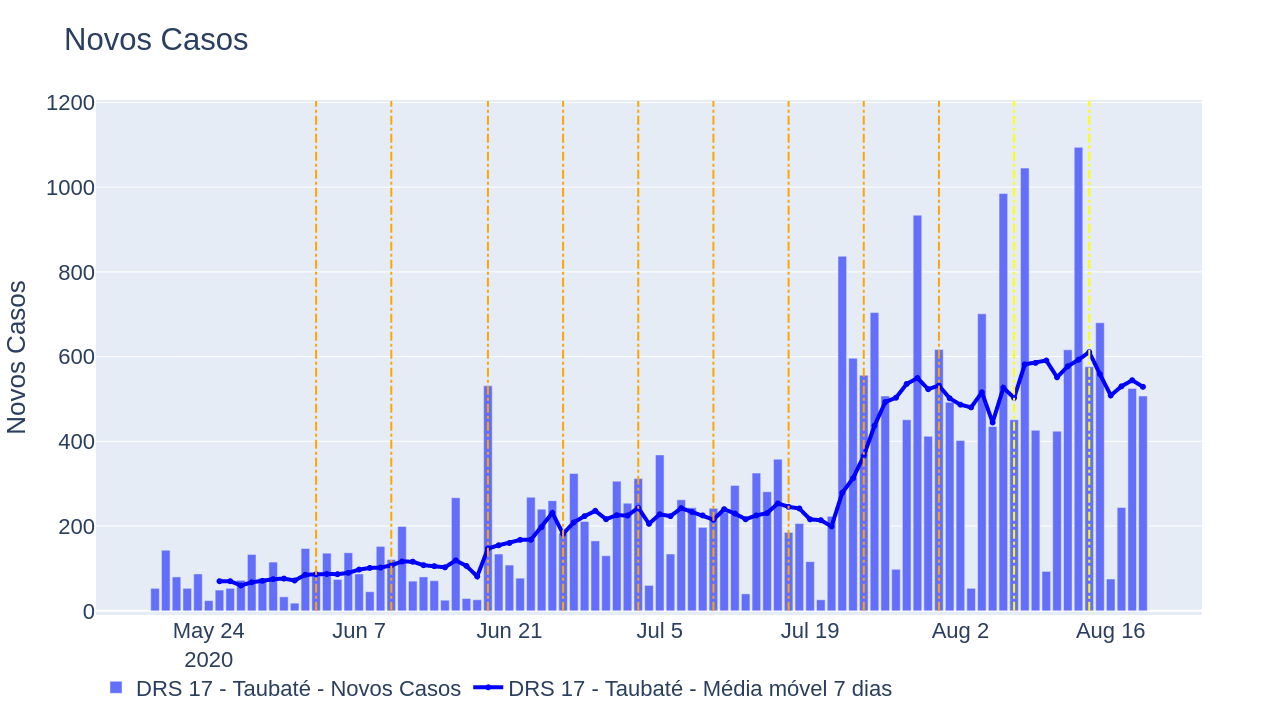

In [40]:
# drs = 'DRS 12 - Registro'
# drs = 'DRS 03 - Araraquara'
# drs = 'DRS 04 - Baixada Santista'
# drs = 'DRS 01 - Município de São Paulo'
drs = 'DRS 17 - Taubaté'



var = 'casos_novos'
var_mm = 'casos_mm7'  #'casos_mm7'
title = 'Novos Casos'





get_figure_bar(final,drs,var,var_mm,title,planosp)


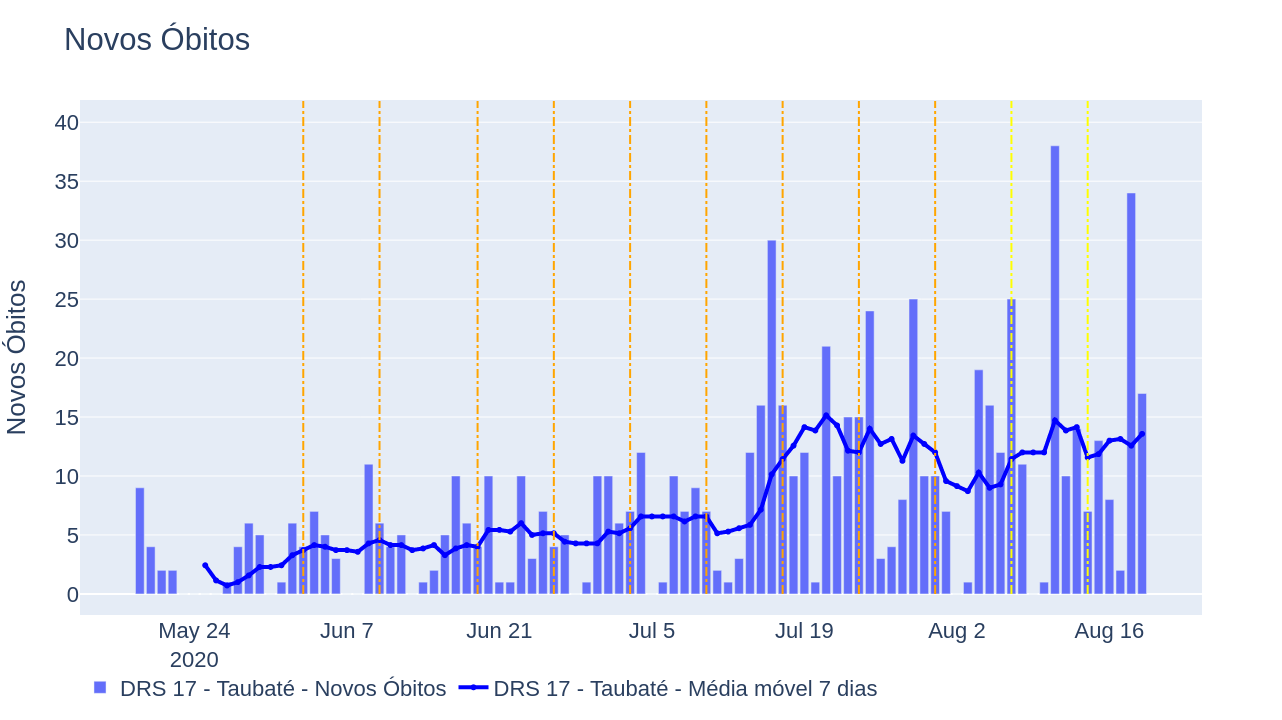

In [41]:
var = 'obitos_novos'
var_mm = 'obitos_mm7'  #'casos_mm7'
title = 'Novos Óbitos'


get_figure_bar(final,drs,var,var_mm,title,planosp)


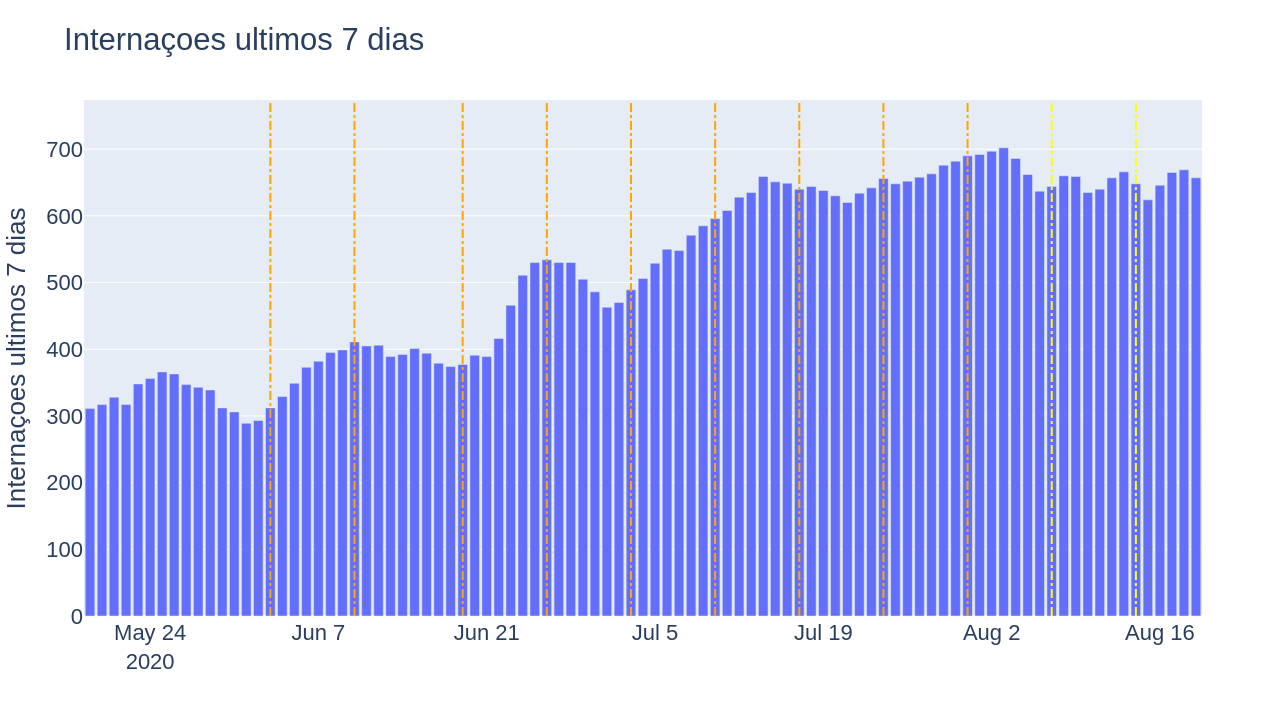

In [42]:
var = 'internacoes_7d'
var_mm = ''  #'casos_mm7'
title = 'Internaçoes ultimos 7 dias'

get_figure_bar(final,drs,var,var_mm,title,planosp)


In [21]:
pop = pd.read_csv('../../brasil_geodata/populacao/populacao_municipios_2001_to_2019.csv')
mask = (pop['ano'] == 2019) & (pop['uf']=='SP')
pop = pop[mask][['geocodigo','populacao']].rename(columns = {"populacao":"pop","geocodigo":"codigo_ibge"})

casos, sp_casos = manipulation_sp.padronize_casos(casos_full)

sp_casos = manipulation_sp.padronize_casos_sp(casos,pop,final)

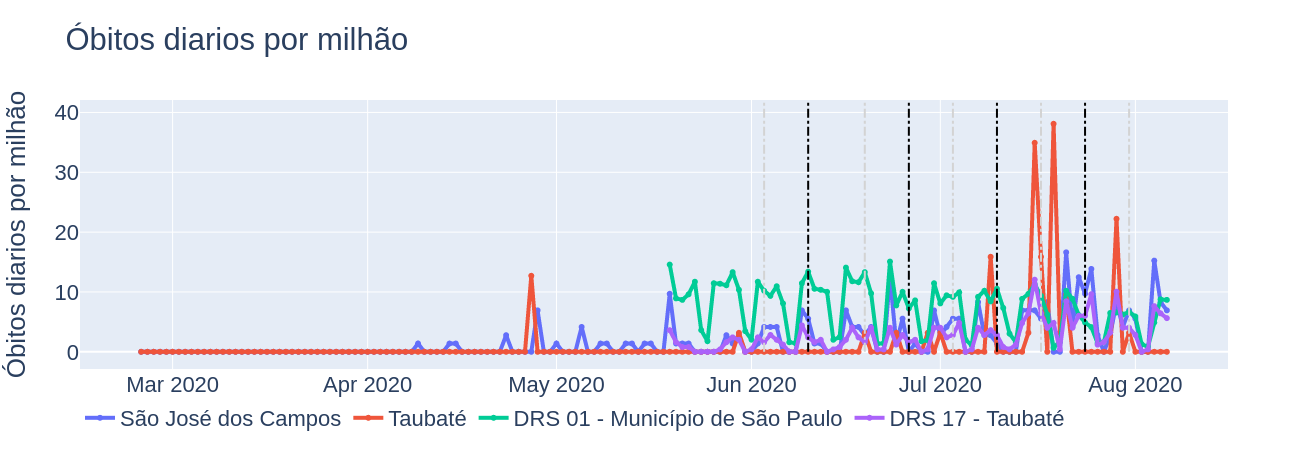

In [22]:
var = 'obitos_pm'
title = 'Óbitos diarios por milhão'

# drs1 = 'DRS 12 - Registro'
drs2 = 'São José dos Campos'
drs3 = 'Taubaté'
drs4 = 'DRS 01 - Município de São Paulo'
drs5 = 'DRS 17 - Taubaté'

# mask  = ssp['nome_drs'].isin([drs1,drs2,drs3,drs4,drs5])
DRSs = [drs2,drs3,drs4,drs5]

get_figure(sp_casos,DRSs,var,title,planosp)


In [ ]:
var = 'casos'
title = 'Casos'

get_figure(sp,mask,var,title)


In [ ]:
var = 'obitos'
title = 'Óbitos'

get_figure(sp,mask,var,title)


In [28]:
def cases_color(val):
    
    for i in range(0,20,1):
        if val == str(i/10):
            color = 'red'
        else:
            pass
    for i in range(20,30,1):
        if val == str(i/10):
            color = 'orange'
        else:
            pass
    for i in range(30,40,1):
        if val == str(i/10):
            color = 'yellow'
        else:
            pass
    for i in range(40,50,1):
        if val == str(i/10):
            color = 'green'
        else:
            pass
        
    return 'background-color: %s' % color

# last_date = df['Data']==max(df['Data'])

# mask = (df['Data']==) | (df['Data']==)

mask = df['DRS'].isin(['DRS 17 - Taubaté'])

pd.options.display.float_format = '{:,.2f}'.format
df[mask].style.applymap(cases_color, subset=pd.IndexSlice[:, ['Capacidade Hospitalar','Evolução da Pandemia','Classif. Final']] )

,Data,DRS,Capacidade Hospitalar,Ocupação leitos UTI COVID,Leitos COVID/100 mil hab,Evolução da Pandemia,Variação de casos,Variação internações,Variação de óbitos,Classif. Final
64,2020-07-09,DRS 17 - Taubaté,4.0,59.8,14.88,2.2,1.0,1.17,1.28,2.2
65,2020-07-16,DRS 17 - Taubaté,4.0,69.2,15.27,2.2,1.13,1.12,1.54,2.2
66,2020-07-23,DRS 17 - Taubaté,4.0,68.7,15.85,2.8,1.23,0.98,1.2,2.8
67,2020-07-30,DRS 17 - Taubaté,4.0,62.9,17.28,2.2,1.67,1.09,1.05,2.2
